## 폐렴 진단 NN | Using CNN
* update 사항 
- [E11]xray.ipynb는 기존 노드와 batchsize, epoch 차이남
- [E11]xray_2.ipynb는 augmentation를 focal_loss로 했다는 점이 차이남
- BatchNormalize만 사용 


In [82]:
# 폐렴(Pneumonia)을 찾아내는 딥러닝 모델을 만드는 것

In [83]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [84]:
os.getcwd()

'/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage'

In [85]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = '/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage'
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 첫 round setting -> xray.h5 model accuracy : 80%
# BATCH_SIZE = 16
# EPOCHS = 25

# 두번째 round setting 
BATCH_SIZE = 32
EPOCHS = 35

print(ROOT_PATH)

/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage


In [86]:
# 데이터 가져오기 (데이터 개수 확인)
# normal과 pneu 두개 합쳐서 들고오는거 
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

# val이 train과 비교했을 때 너무 모자람

5216
624
16


In [87]:
train_filenames[:10]

['/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg',
 '/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg',
 '/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/chest_xray/train/NORMAL/IM-0427-0001.jpeg',
 '/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg',
 '/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg',
 '/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/chest_xray/train/NORMAL/IM-0561-0001.jpeg',
 '/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/chest_xray/train/NORMAL/NORMAL2-IM-1110-0001.jpeg',
 '/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/chest_xray/train/NORMAL/IM-0757-0001.jpeg',
 '/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_

***[TIP]***  

`tf.gfile.GFile( )은 tensorflow 구조에 특화된 파일 입출력 함수`  

일반적으로 사용했던 Io 텍스트 입출력 함수와 비슷하게 사용됨 

`import tensorflow as tf`  
 
`with open('test.txt', 'w') as f: f.write('test')`  
 
`with tf.gfile.GFile('test.txt', 'r') as f: print(f.read())`   
 
`with tf.gfile.GFile('test2.txt', 'w') as f: f.write('test2')`  
 
`with open('test2.txt', 'r') as f: print(f.read())`  

<br>

***[TIP] `tf.io.gfile.glob()` : Returns a list of files that match the given pattern(s)***

In [88]:
# train과 val 모아서 train:val = 0.8:0.2

# train 데이터와 validation 데이터를 모두 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눔 
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))



4185
1047


***[TIP] `Math.floor()` 함수는 주어진 숫자와 같거나 작은 정수 중에서 가장 큰 수를 반환***

In [89]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/chest_xray/train/NORMAL/NORMAL2-IM-0561-0001.jpeg
Pneumonia image path
/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/chest_xray/train/PNEUMONIA/person326_bacteria_1505.jpeg


In [90]:
# 파일경로에 NORMAL이 있으면 정상 이미지
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f'Normal images count in training set: {COUNT_NORMAL}')

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f'Pneumonia images count in training set: {COUNT_PNEUMONIA}')

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


CNN 모델은 데이터가 클래스별 balance가 좋을수록 training이 잘 됨  

데이터 클래스 imbalance는 뒤에서 조절할 예정  

(test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제 없음)

### tf.data 

- tf.data 인스턴스를 이용해 tf 학습 내 배치처리 작업을 효율적으로 진행  
- tf.data API는 유연하고 효율적인 입력 파이프라인을 만드는데 도움 제공
- [tf.data : Tensorflow 입력 파이프라인](https://www.tensorflow.org/guide/data?hl=ko)

In [91]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [92]:
train_list_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [93]:
# train, val 데이터 셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


***[TIP]***  

`tf.data.experimental.cardinality(dataset)` : Returns the cardinality of dataset, if known.

cardinality 사전적 정의: 관계 데이터베이스에서 하나의 릴레이션을 구성하는 튜플의 개수, 또는 하나의 데이터 타입으로 정의되는 데이터 레코드의 개수

In [94]:
# 파일경로를 사용하여 라벨 데이터 만들어주는 함수 
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA' # pneu면 True, nor이면 False

***[TIP]***  

1. `tf.strings.split(input, sep=None, maxsplit=-1, name=None)` :Split elements of input based on sep into a RaggedTensor.  

2. `os.path.sep` : 파일 경로를 os.path.sep(OS별 파일 경로 나는 문자)를 이용해 split

In [95]:
# os.path.sep 테스트 

a = '/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/chest_xray/train/NORMAL/NORMAL2-IM-0561-0001.jpeg'
a = tf.strings.split(a, os.path.sep)
print(a)

tf.Tensor(
[b'' b'Users' b'js8456' b'google_drive' b'Colab_Notebook' b'aiffel_lms'
 b'E11_XrayImage' b'chest_xray' b'train' b'NORMAL'
 b'NORMAL2-IM-0561-0001.jpeg'], shape=(11,), dtype=string)


이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높기 떄문에 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 shrink  

decode_img 함수와 process_path 함수를 만들고, process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경

get_label을 이용해서 라벨 값을 가져오도록 함

In [96]:
# 이미지 사이즈 통일시키고, 사이즈도 줄이기 
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels = 3) # 이미지를 unit8 tensor로 변경 
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정 
    img = tf.image.resize(img, IMAGE_SIZE) # 위에서 세팅해놓은 IMAGE_SIZE로 변경
    return img

# 이미지 파일 경로를 입력하면 이미지와 라벨을 읽어오기 
def process_path(file_path):
    label = get_label(file_path) #라벨 검출 
    img = tf.io.read_file(file_path) #이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정 
    return img, label

***[TIP]***  

`tf.image.convert_image_dtype(img, dtype, saturate = False, name = None)`  

The operation supports data types (for image and dtype) of uint8, uint16, uint32, uint64, int8, int16, int32, int64, float16, float32, float64, bfloat16.

Images that are represented using floating point values are expected to have values in the range [0,1]. Image data stored in integer data types are expected to have values in the range [0,MAX], where MAX is the largest positive representable number for the data type.  

This op converts between data types, scaling the values appropriately before casting.  

floating point로 표시되는 이미지는 [0,1] 사이의 값을 예상하는데, Integer data 타입의 이미지는 [0, MAX] 사이의 값을 갖고 있다. 그래서 캐스팅 전에 tf.image.conver_image_dtype을 이용하여 유형간 변환을 진행한다. 

[출처](https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype)

***[TIP]***  

`tf.io.decode_jpeg(
    contents, channels=0, ratio=1, fancy_upscaling=True,
    try_recover_truncated=False, acceptable_fraction=1, dct_method='',
    name=None
)  `

Decode a JPEG-encoded image to a uint8 tensor.

In [97]:
type(train_list_ds)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [98]:
# train dataset & validation dataset 생성 
# num_parallel_calls를 이용해서 초기화한 AUTOTUNE을 이용하면 데이터 처리를 더 빠르게 할 수 있음 

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [99]:
# 리사이징 확인 
# train_ds.take(1)은 하나의 데이터만 가져온다는 의미

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


repeat(): 데이터 셋을 반복한다.

batch(): 데이터 배치의 크기를 정한다. (위의 코드에서는 1배치 당 8개의 데이터)

take(): 해당 배치를 몇 번 불러올지 정한다. (배치를 10번 불러온다)

[참고](https://deep-deep-deep.tistory.com/27)  

[tf.data 유튜브 영상](https://www.youtube.com/watch?v=kVEOCfBy9uY)

In [100]:
# test 데이터셋도 위와 동일한 방법으로 만들기 
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


tf.data 파이프라인을 이용하면 학습 데이터를 효율적으로 사용할 수 있음  

`prepare_for_training()` 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시킴  

- `shuffle()`: 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택

- `repeat()`: epoch를 진행하면서 여러 번 데이터셋을 불러오는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용 가능함. 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줌

- `batch()`: BATCH_SIZE에서 정한 만큼의 배치로 제공. 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터가 세팅됨

- `prefetch()`: 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음

In [101]:
# type 확인
train_ds

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>

In [79]:
# # data augmentation 없을 때의 prepare_for_training 

# def prepare_for_training(ds, shuffle_buffer_size = 1000):
#     ds = ds.shuffle(buffer_size = shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size = AUTOTUNE)
#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

In [102]:
# data augmentation이 있을 때의 prepare_for_training 

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment,       
                num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [103]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

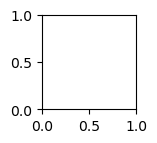

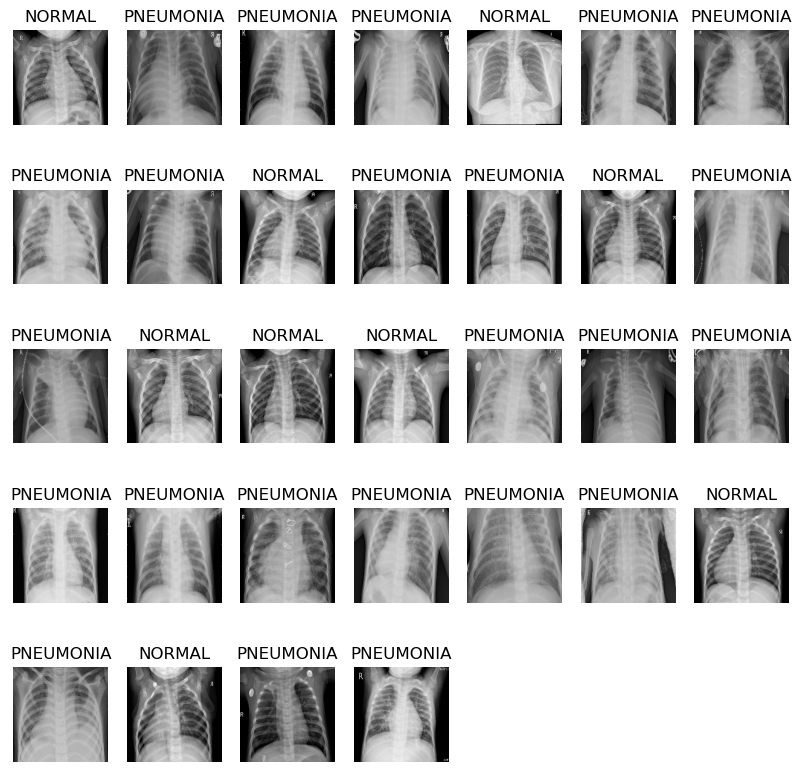

In [104]:
# 데이터 시각화 
# train에 있는 batch 중 첫번쨰 batch 추출. 첫번째 batch를 image와 label 데이터셋으로 나눠. 

def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10, 10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5, math.ceil(BATCH_SIZE/5), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')
    plt.show()

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

[TIP]  

1. [math library](https://ooyoung.tistory.com/99)  

2. `math.ceil()`ceil 함수는 실수를 입력하면 올림 하여 정수를 반환하는 함수이다. ceil은 천장을 의미하는 단어이기 때문에 어떤 실수의 천장을 의미하는 바로 위 정수를 반환한다고 기억하면 좋다.



### CNN Modeling 
- [CNN 요약](http://taewan.kim/post/cnn/)


In [105]:
# Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결한 후 Max Pooling

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation= 'relu', padding = 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
        ])
    return block

In [106]:
# dense block 
# (units, dropout_rate)에서 dropout 제거, modeling에서도 제거 
def dense_block(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(dropout_rate)
    ])
    return block 

In [142]:
def dense_block2(units):
    block = tf.keras.Sequential([
            tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units, activation = 'relu'),
        # tf.keras.layers.Dropout(dropout_rate)
    ])
    return block 

Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용하는 모델로 진행   

***[TIP]***  

1. variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 주장하는 논문  

- [논문1](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)

2. 동시에 사용하는 것이 성능 향상에 도움을 준다라고 주장하는 논문 
- [논문2](https://arxiv.org/pdf/1905.05928.pdf)

In [107]:
IMAGE_SIZE

[180, 180]

In [108]:

def build_model():
    model = tf.keras.Sequential([
            tf.keras.Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
            tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
            tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
            tf.keras.layers.MaxPool2D(),

            conv_block(32),
            conv_block(64),

            conv_block(128),
        #     tf.keras.layers.Dropout(0.2),

            conv_block(256),
        #     tf.keras.layers.Dropout(0.2),

            tf.keras.layers.Flatten(),
            dense_block(512),
            dense_block(128),
            dense_block(64),

            tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [146]:

def build_model2():
    model = tf.keras.Sequential([
            tf.keras.Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
            tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
            tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
            # tf.keras.layers.MaxPool2D(),

            conv_block(32),
            conv_block(64),

            conv_block(128),
        #     tf.keras.layers.Dropout(0.2),

            conv_block(256),
        #     tf.keras.layers.Dropout(0.2),

            tf.keras.layers.Flatten(),
            # dense_block(512),
            # dense_block(128),
            dense_block2(64),

            tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

### Data Imbalance 처리 
***이 노트북에서는 Focal Loss를 사용하기 위해서 `from focal_loss import BinaryFocalLoss` 사용***

리스크가 더 큰 선택지에는 더욱 큰 비중을 두어야 정확한 예측이 가능하다. 여기에서는 폐렴에 걸렸다는 것이 더 큰 비중이니까 loss를 더 크게.  

지금 데이터는 리스크가 더 큰 pneu보다 nor에 더 많은 data가 있기 때문에 클래스 불균형이 있다고 말할 수 있지(nor 데이터가 더 많기 때문에 nor이라고 맞게 예측할 수 있는 가능성은 높은데, pneu는 반대이기 떄문에)  

만약 소수 클래스에 관심이 없고 단지 accuracy만 중요하다면 Imbalance여도 아무 문제 없음  
<br>

#### *해결방법 
**Loss Function Level**
1. Weight balancing(Weighted Cross Entropy)
    - training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
    - 지금 문제에서는 pneu 클래스에 더 높은 정확도가 필요하기 때문에 pneu 클래스에 관해서 loss가 더 크게 만들어야 함 
    - 원하는 클래스의 데이터의 loss에는 특정값을 multiply and then process learning step 
    - Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있음
    - [참고페이지](https://3months.tistory.com/414)  

2. Focal Loss
    - Cross Entropy에 Gamma와 Weight를 추가해 잘 맞추는 클래스에 대한 Loss 값을 줄여 갱신 속도를 늦춰주는 손실함수
    - Easy class에는 작은 가중치, Hard class에는 큰 가중치를 부여, 학습이 어려운 class에 비중을 더 줌 
    - 클래스 비율에 따라 가중치를 두는 법 
    - 감마는 보통 2를 최적값으로 사용함 
    - `from focal_loss import BinaryFocalLoss` 사용해봄 
    - [focal_loss github](https://github.com/artemmavrin/focal-loss)

**Data Level**
1. 오버샘플링, 언더샘플링 

In [145]:
# weight 방법 1 : Weight Balancing 
# weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅
# weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0 

class_weight = {0:weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [110]:
# !pip install git+https://github.com/artemmavrin/focal-loss.git

### Model Training 
- GPU 사용 setting 
- 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언

- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용
- optimizer 'adam' 사용
- 성과 측정 metrics으로 'accuracy', 'precision', 'recall'을 사용

In [111]:
#model 생성시 _ build_model 세트
from focal_loss import BinaryFocalLoss

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name = 'precision'),
            tf.keras.metrics.Recall(name = 'recall')
    ]

    model.compile(
        optimizer = 'adam',
        loss = BinaryFocalLoss(gamma = 2),
        metrics = METRICS
    )

In [151]:
# build_model2이용, Focal loss 대신 weight balance 사용 

with tf.device('/GPU:0'):
    model_new = build_model2()

    METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name = 'precision'),
            tf.keras.metrics.Recall(name = 'recall')
    ]

    model_new.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)

In [112]:
ROOT_PATH

'/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage'

In [113]:
# Model Checkpoint
checkpoint_path = ROOT_PATH + '/xray_3_check_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = False, 
    monitor = 'val_loss',
    save_best_only = False,
    mode = 'auto',
    save_freq = 'epoch',
    verbose = 1
)


with tf.device('/GPU:0'):
    history = model.fit(
        train_ds, 
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        callbacks = [model_checkpoint_callback],
        validation_data = val_ds, 
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        # class_weight = class_weight,
    )

Epoch 1/35
130/130 [==============================] - 169s 1s/step - loss: 0.0805 - accuracy: 0.9127 - precision: 0.9572 - recall: 0.9241 - val_loss: 0.1473 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000

Epoch 00001: saving model to /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/xray_3_check_checkpoint
INFO:tensorflow:Assets written to: /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/xray_3_check_checkpoint/assets
Epoch 2/35
130/130 [==============================] - 158s 1s/step - loss: 0.0326 - accuracy: 0.9553 - precision: 0.9676 - recall: 0.9726 - val_loss: 0.1934 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000

Epoch 00002: saving model to /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/xray_3_check_checkpoint
INFO:tensorflow:Assets written to: /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/xray_3_check_checkpoint/assets
Epoch 3/35
130/130 [======================

In [117]:
model.save(f'xray_3_batchsize{BATCH_SIZE}_epoch{EPOCHS}.h5')

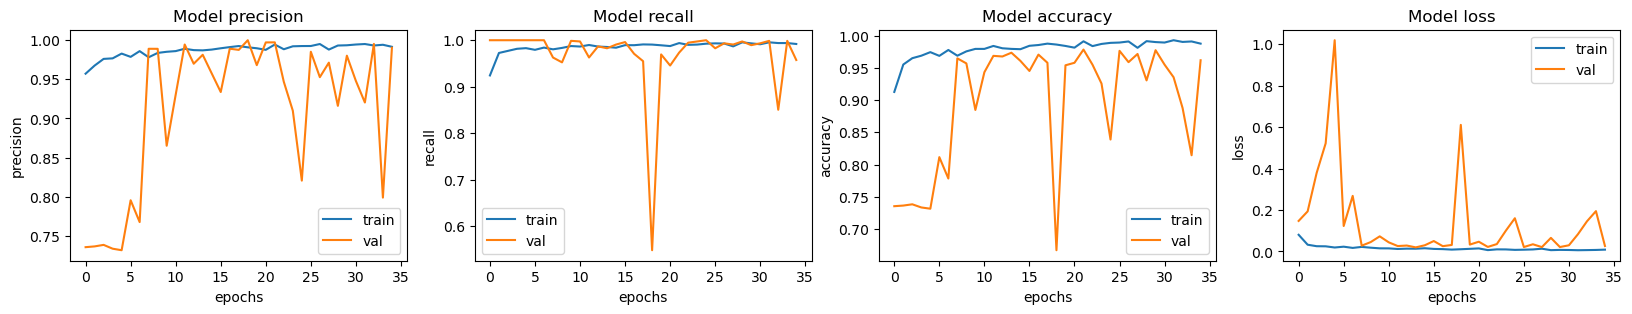

In [115]:
# 결과 확인 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met]) # 
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()

***[TIP]***  

다차원 배열(array)을 1차원 배열로 평평하게 펴주는 NumPy의 `ravel()` 함수, `flatten()`함수 

1차원 배열을 다차원 배열로 재구성/재배열 해주는 NumPy의 reshape() 함수와 반대의 기능을 하는 함수가 ravel(), flatten() 함수

출처: https://rfriend.tistory.com/349 [R, Python 분석과 프로그래밍의 친구 (by R Friend)]
 

### Model Test 1
- 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력

In [116]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, \n Accuracy: {accuracy} \n Precision: {precision}, \n Recall : {recall}')

20/20 [==============================] - 6s 294ms/step - loss: 0.3040 - accuracy: 0.8381 - precision: 0.8017 - recall: 0.9846
Loss: 0.30403387546539307, 
 Accuracy: 0.8381410241127014 
 Precision: 0.8016701340675354, 
 Recall : 0.9846153855323792


## 더 높은 Acc 위해 진행 


### Model Test 2 | val_accuracy 가장 높은 Epoch22 Model 사용 

In [124]:
os.listdir(checkpoint_path)

['keras_metadata.pb', 'variables', 'saved_model.pb', 'assets']

In [138]:
# The model weights (that are considered the best) are loaded into the model.

with tf.device('/GPU:0'):
    model_best = build_model()
    model_best.load_weights(checkpoint_path.format(epoch = 22))

    model_best.compile(
        optimizer = 'Adagrad',
        loss = BinaryFocalLoss(gamma = 2),
        metrics = METRICS
    )

In [139]:
loss, accuracy, precision, recall = model_best.evaluate(test_ds)
print(f'Loss: {loss}, \n Accuracy: {accuracy} \n Precision: {precision}, \n Recall : {recall}')

20/20 [==============================] - 7s 325ms/step - loss: 0.3040 - accuracy: 0.8381 - precision: 0.8017 - recall: 0.9846
Loss: 0.3040338456630707, 
 Accuracy: 0.8381410241127014 
 Precision: 0.8016701340675354, 
 Recall : 0.9846153855323792


### Model Test 3 |일반 acc가 가장 높았던 Epoch32 사용
- 차이 없음 

In [140]:
# The model weights (that are considered the best) are loaded into the model.

with tf.device('/GPU:0'):
    model_best2 = build_model()
    model_best2.load_weights(checkpoint_path.format(epoch = 32))

    model_best2.compile(
        optimizer = 'Adam',
        loss = BinaryFocalLoss(gamma = 2),
        metrics = METRICS
    )

In [141]:
loss, accuracy, precision, recall = model_best2.evaluate(test_ds)
print(f'Loss: {loss}, \n Accuracy: {accuracy} \n Precision: {precision}, \n Recall : {recall}')

20/20 [==============================] - 8s 320ms/step - loss: 0.3040 - accuracy: 0.8381 - precision: 0.8017 - recall: 0.9846
Loss: 0.30403387546539307, 
 Accuracy: 0.8381410241127014 
 Precision: 0.8016701340675354, 
 Recall : 0.9846153855323792


### ***Model Test 4 | 새롭게 modeling _ model_new : Accuracy 85.57%***

In [152]:
# Model Checkpoint
checkpoint_path2 = ROOT_PATH + '/xray_3_2_check_checkpoint'
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path2,
    save_weights_only = False, 
    monitor = 'val_loss',
    save_best_only = False,
    mode = 'auto',
    save_freq = 'epoch',
    verbose = 1
)


with tf.device('/GPU:0'):
    history = model_new.fit(
        train_ds, 
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        callbacks = [model_checkpoint_callback2],
        validation_data = val_ds, 
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight,
    )

Epoch 1/35
130/130 [==============================] - 333s 2s/step - loss: 0.1983 - accuracy: 0.9171 - precision: 0.9745 - recall: 0.9125 - val_loss: 0.6943 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000

Epoch 00001: saving model to /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/xray_3_2_check_checkpoint
INFO:tensorflow:Assets written to: /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/xray_3_2_check_checkpoint/assets
Epoch 2/35
130/130 [==============================] - 333s 3s/step - loss: 0.0906 - accuracy: 0.9630 - precision: 0.9887 - recall: 0.9613 - val_loss: 0.7686 - val_accuracy: 0.7305 - val_precision: 0.7305 - val_recall: 1.0000

Epoch 00002: saving model to /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/xray_3_2_check_checkpoint
INFO:tensorflow:Assets written to: /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E11_XrayImage/xray_3_2_check_checkpoint/assets
Epoch 3/35
130/130 [==============

In [153]:
loss, accuracy, precision, recall = model_new.evaluate(test_ds)
print(f'Loss: {loss}, \n Accuracy: {accuracy} \n Precision: {precision}, \n Recall : {recall}')

20/20 [==============================] - 14s 681ms/step - loss: 2.7613 - accuracy: 0.8558 - precision: 0.8713 - recall: 0.9026
Loss: 2.76134991645813, 
 Accuracy: 0.8557692170143127 
 Precision: 0.8712871074676514, 
 Recall : 0.9025641083717346


### 결과 
- Batchsize 및 Epoch 변경, 이미지 Augmentation, weight balancing 대신 Focal Loss 사용, Dropout & BatchNormalize 동시 사용/각자 사용 등의 방법을 사용하여 Accuracy를 높이고자 했음
- 그 결과 Batchsize 32, Epoch 35, Augmentation(left&right), weight balance, Dropout 단독 사용, Maxpooling 제거를 진행한 해당 노트북의 결과인 ***Accuracy 85.6%*** 를 얻을 수 있었음

### 회고 
- `model.checkpoint`, `model.save` 관련해서 깊게 살펴봐야 함을 다시 한번 느낌 
- checkpoint 저장할 때 경로 지정 변수에 epoch 값 함께 저장될 수 있도록 epoch format 제공해야 함 인지 
- `tf.data`가 파이프라인 설계에 도움되는 부분은 알았으나, 이렇게 사용 가능한 코드가 많다는 것은 인지하지 못했음. 이번 기회를 통해 해당 부분 공부를 진행하고자 함
- Focal Loss 적용을 위한 BinaryFocalLoss를 제외한 다른 function 혹은 tf의 기본 모델을 확인해보고자 함 
- 다른 조건을 동일하게 세팅하고 optimizer를 변경했을 때, Accuracy에는 많은 차이가 없었음을 확인 